<b style="font-size:30px; line-height:1.2"><center>Стратегия взаимодействия с клиентами на основе аналитических данных сети фитнес-центров<br>«Культурист-датасаентист»</b></center>

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

**Основная задача:** провести анализ и подготовить план действий по удержанию клиентов.

Имеется данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.

Этапы достижения основной задачи:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
   - 1) выделить целевые группы клиентов;
   - 2) предложить меры по снижению оттока;
   - 3) определить другие особенности взаимодействия с клиентами.

# Шаг №1.  Загрузить данные и изучить их

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

Структура **DF:**
 - **Churn** — факт оттока в текущем месяце;

Данные клиента за предыдущий до проверки факта оттока месяц:
 - **gender** — пол;
 - **Near_Location** — проживание или работа в районе, где находится фитнес-центр;
 - **Partner** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - **Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - **Phone** — наличие контактного телефона;
 - **Age** — возраст;
 - **Lifetime** — время с момента первого обращения в фитнес-центр (в месяцах).
 
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
 - **Contract_period** — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
 - **Month_to_end_contract** — срок до окончания текущего действующего абонемента (в месяцах);
 - **Group_visits** — факт посещения групповых занятий;
 - **Avg_class_frequency_total** — средняя частота посещений в неделю за все время с начала действия абонемента;
 - **Avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц;
 - **Avg_additional_charges_total** — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

# Шаг 2. Исследовательский анализ данных (EDA)

Загрузим DF:

In [3]:
df = pd.read_csv('gym_churn.csv')

Проверим какая доля пропущенных значений в каждом столбце:

In [4]:
report = df.isna().sum().to_frame()
report = report.rename(columns = {0: 'Количество пропусков'})
report['Доля пропусков, %'] = (report['Количество пропусков'] * 100/ df.shape[0]).round(1)
report.sort_values(by = 'Количество пропусков', ascending = False)

,Количество пропусков,"Доля пропусков, %"
gender,0,0.0
Near_Location,0,0.0
Partner,0,0.0
Promo_friends,0,0.0
Phone,0,0.0
Contract_period,0,0.0
Group_visits,0,0.0
Age,0,0.0
Avg_additional_charges_total,0,0.0
Month_to_end_contract,0,0.0


**Вывод:** пустых значений в признаках нет. Проверим на наличие дубликатов:

In [5]:
print('Количество дубликатов = {:.0f}'.format(df.duplicated().sum()))

Количество дубликатов = 0


Проверим средние значения и стандартные отклоения:

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Вывод:** для каждого признака присутствуют разные значения, то есть нет такого, чтобы для всех объектов какой-то признак имел одно и то же значение.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [7]:
df.groupby('Churn').mean().reset_index(drop=True).T.rename(columns = {0: 'Отток', 1: 'Оставшиеся'})

,Отток,Оставшиеся
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


**Вывод**: неоднозначный вывод, но пол человека, номер телефона исклюим из списка признаков, влиющих на причину оттока.

Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

Создадим список категориальных признаков:

In [8]:
attribute_list = ['Group_visits', 'Near_Location', 'Partner', 'Phone', 'Promo_friends', 'gender',
             'Contract_period', 'Age', 'Lifetime', 'Month_to_end_contract']
title_attribute = ['Посещение групповых занятий', 'Проживание или работа в районе с фитнес-клубом',
              'Сотрудник компании-партнёра', 'Наличие контактного телефона',
              'Факт первоначальной записи в рамках акции «приведи друга»', 'Пол',
              'Длительность текущего действующего абонемента', 'Возраст',
              'Время с момента первого обращения в фитнес-клуб (в месяцах)',
              'Срок до окончания текущего действующего абонемента (в месяцах)']
label_attribute = [['без групповых занятий', 'с групповыми занятиями'], ['в другом районе', 'рядом с клубом'],
              ['не сотрудники', 'сотрудники'], ['без телефонов', 'с телефонами'],
              ['не от друзей', 'от друзей'], ['женщины', 'мужчины'], ['', ''], ['', ''], ['', ''], ['', '']]

Напишем функцию для отображения необходимых графиков:

In [9]:
def print_bar(df, attribute, title, label):
    #Создадим DF для отображения графиков
    df_attribute = df[[attribute, 'Churn', 'Avg_class_frequency_total']].groupby(['Churn',attribute]).agg(
        {'Avg_class_frequency_total':'count'}).reset_index().rename(columns = {'Avg_class_frequency_total':'count'})
    #Переведем в строковый формат, для удобства при работе с Plotly
    df_attribute.loc[df_attribute['Churn'] == 0, 'Churn'] = 'оставшиеся'
    df_attribute.loc[df_attribute['Churn'] == 1, 'Churn'] = 'ушедшие'
    df_attribute = df_attribute.rename(columns = {'Churn': 'Отток'})
    #Промежуточный DF для определения процентного соотношения
    df_between = df_attribute.groupby(attribute).agg(
        {'count':'sum'}).reset_index().rename(columns = {'count':'total_count'})
    #Определяем долю в процентах
    df_attribute = df_attribute.merge(df_between, on = attribute)
    df_attribute['percent'] = ((df_attribute['count'] / df_attribute['total_count'])*100).round(2).astype('str')+'%'
    #Отображаем графики
    df_attribute[attribute] = df_attribute[attribute].replace(0,label[0])
    df_attribute[attribute] = df_attribute[attribute].replace(1,label[1])
    fig = px.bar(df_attribute, x=attribute, y='count', color='Отток', barmode='group',  width=800, height=400,
                 text = df_attribute['percent'],
                 hover_data={'Количество':df_attribute['count'],
                             'Процент':df_attribute['percent'],
                             'percent':False,
                             'count':False,
                            'Отток':False,
                             attribute:False
                            }
                )
    fig.update_layout(
        title=title,
        xaxis_title = '',
        yaxis_title = 'Кол-во')
    fig.update_traces(textposition = "auto")
    fig.show('svg')

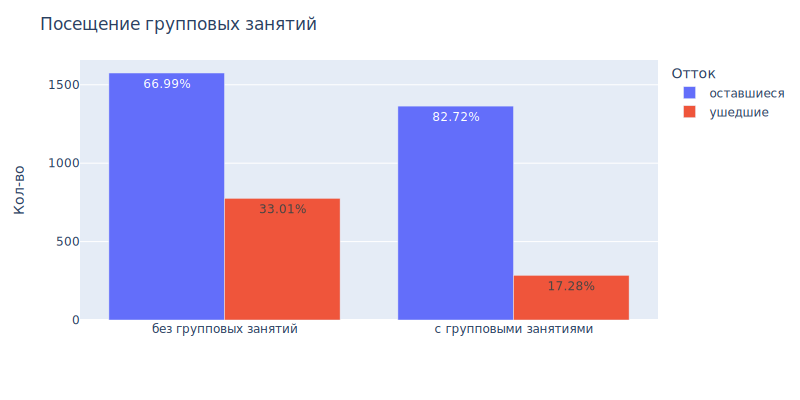

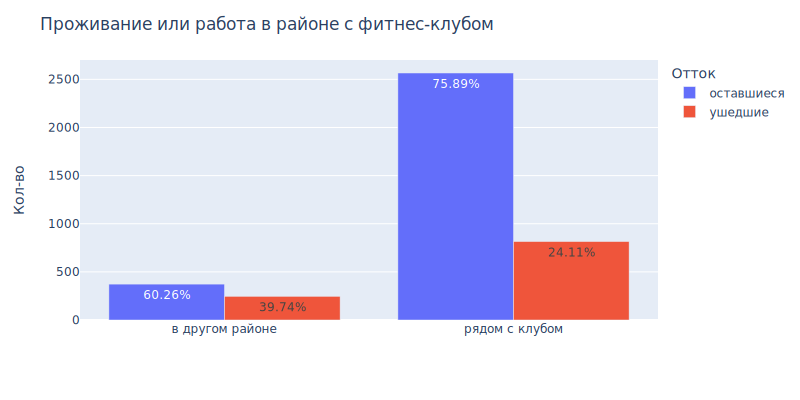

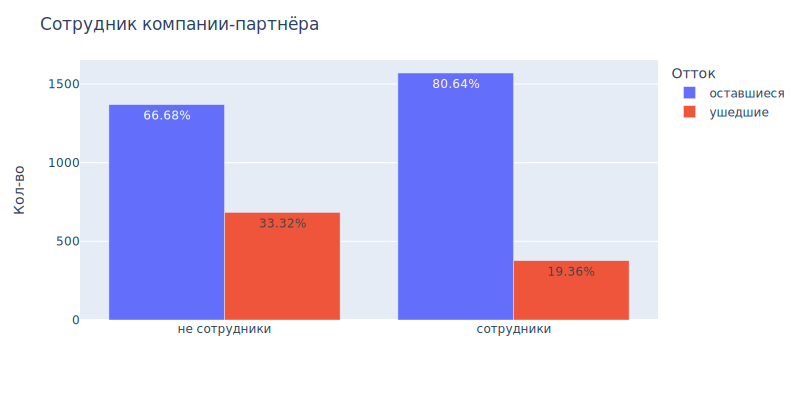

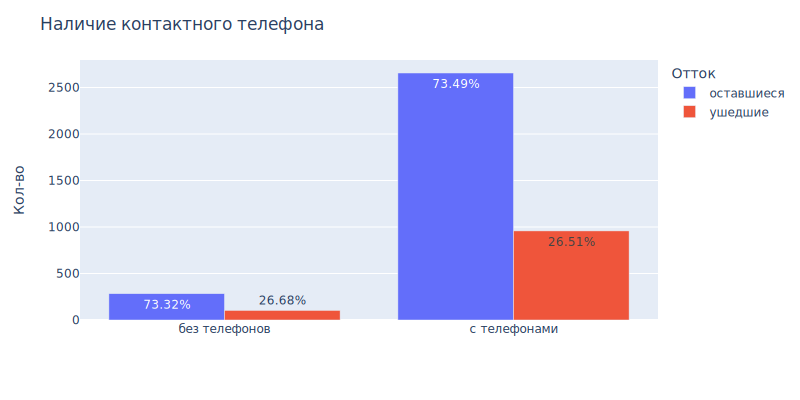

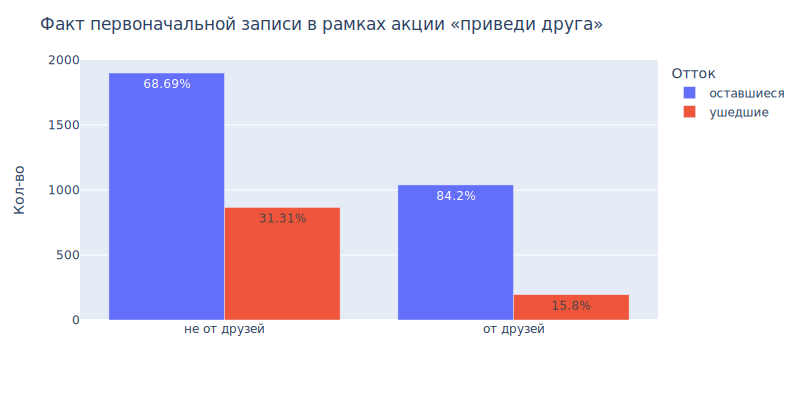

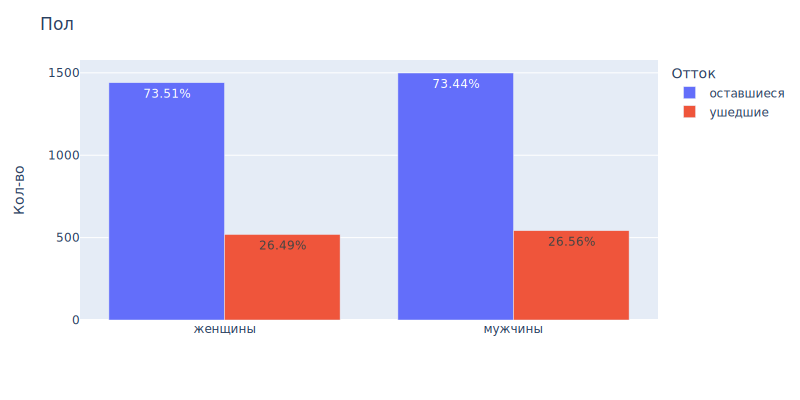

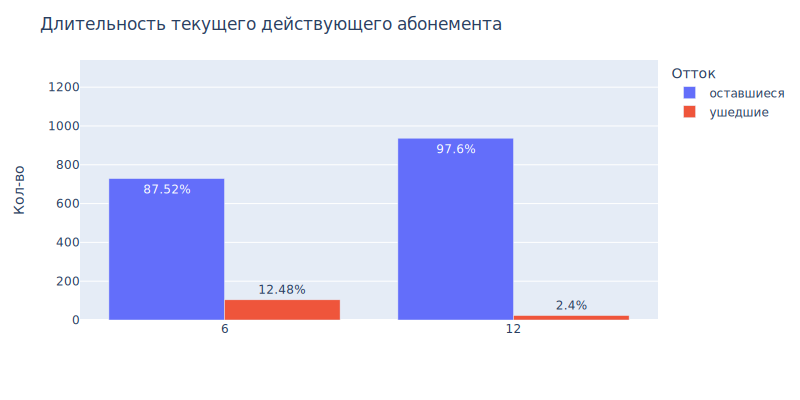

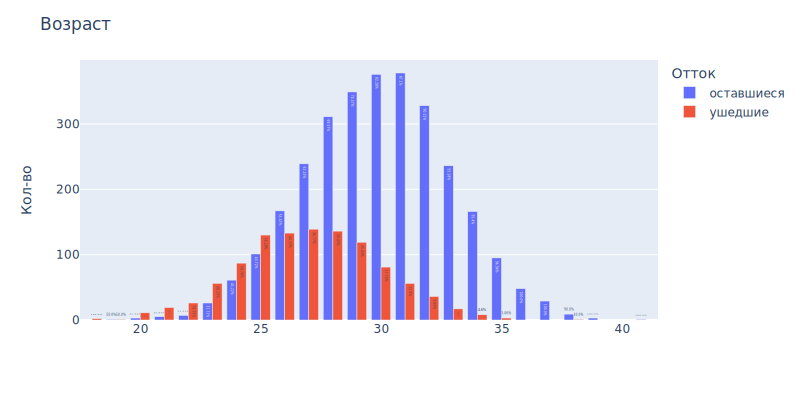

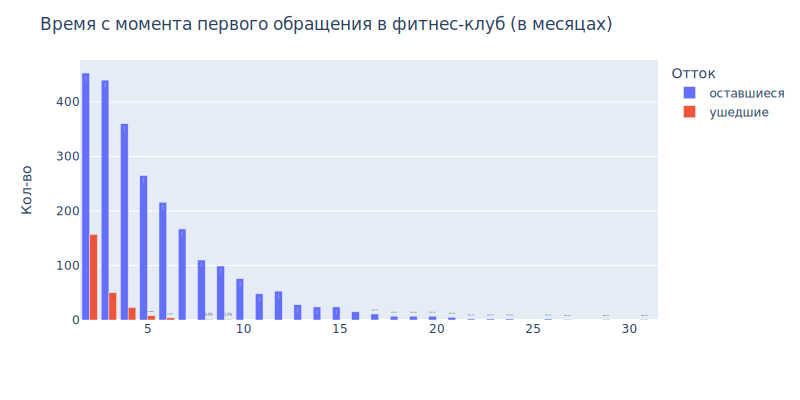

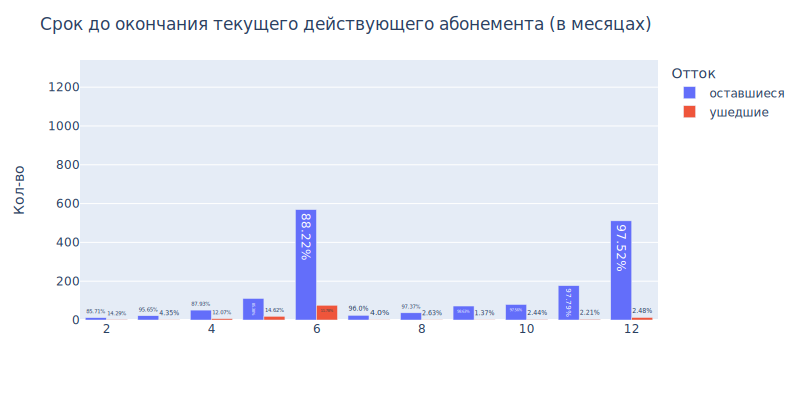

In [10]:
for attribute, title, label in zip(attribute_list, title_attribute, label_attribute):
    print_bar(df, attribute, title, label)

**Вывод:** Можно заметить, что доля ушедших при отсутствии признака (не посещали группы, не сотрудники компаний-партнёров и т.д.) почти в 2 раза выше, чем при наличии признака.
Доля оттока по признакам наличия телефона в базе и гендерной принадлежности для обеих категорий признаков примерно одинакова, как и предполагалось.

Построим тепловую карту матрицы кореляции:

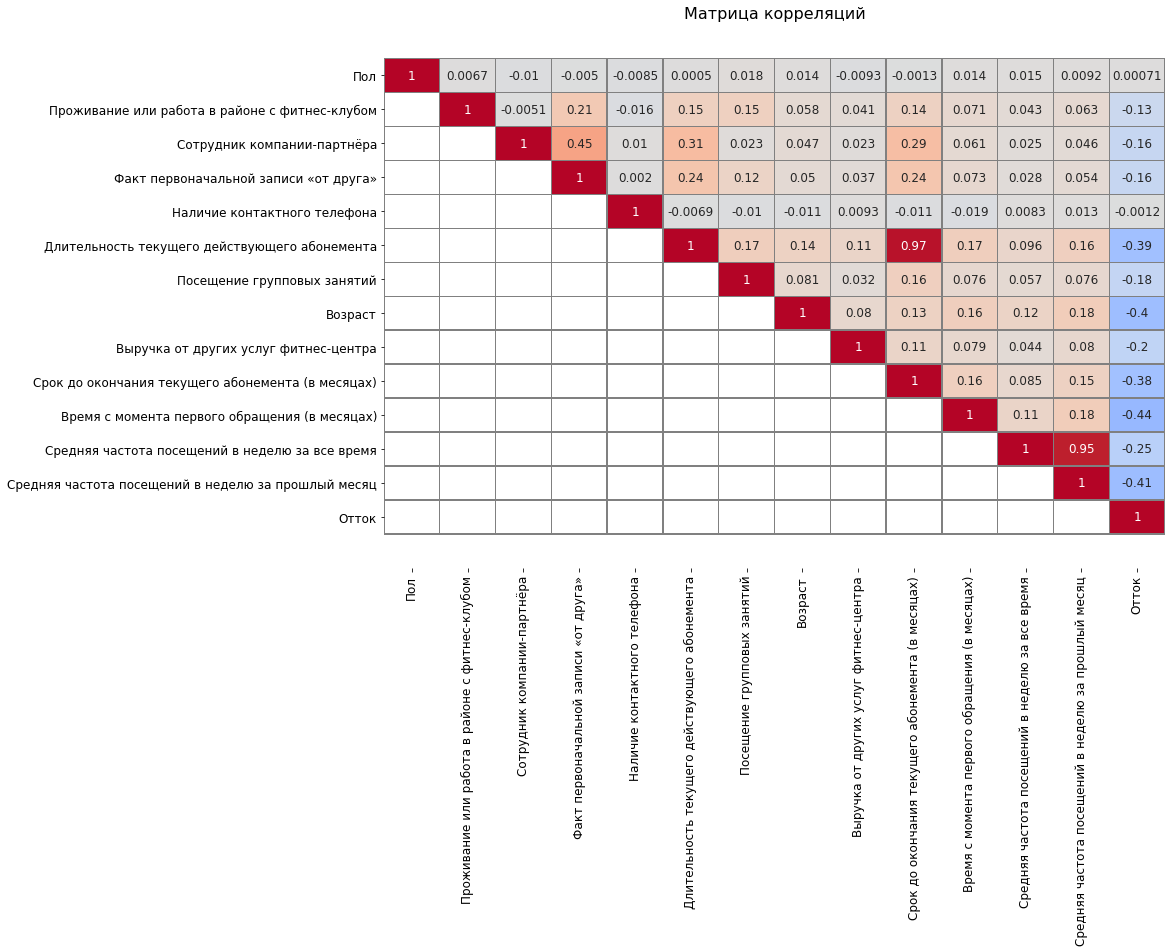

In [11]:
mark_list = ['Group_visits', 'Near_Location', 'Partner', 'Phone', 'Promo_friends', 'gender',
             'Contract_period', 'Age', 'Lifetime', 'Month_to_end_contract',
             'Avg_additional_charges_total', 'Avg_class_frequency_current_month',
             'Avg_class_frequency_total', 'Churn']
title_list = ['Посещение групповых занятий', 'Проживание или работа в районе с фитнес-клубом',
              'Сотрудник компании-партнёра', 'Наличие контактного телефона',
              'Факт первоначальной записи «от друга»', 'Пол',
              'Длительность текущего действующего абонемента', 'Возраст',
              'Время с момента первого обращения (в месяцах)',
              'Срок до окончания текущего абонемента (в месяцах)',
              'Выручка от других услуг фитнес-центра', 'Средняя частота посещений в неделю за прошлый месяц',
              'Средняя частота посещений в неделю за все время', 'Отток']
mark_dict = {}
for i in range(len(mark_list)):
    mark_dict[mark_list[i]] = title_list[i]

corr = df.corr()
lower = np.tril(corr, k=-1)
f, ax = plt.subplots(figsize = (14, 10))
annot_kws = {'fontsize': 12, 'verticalalignment': 'center'}
ax = sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, annot_kws = annot_kws,
                 annot = True, mask = lower,
                 linewidths = 0.5, linecolor = 'gray', cmap= 'coolwarm', cbar=False,
                )
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 1, top - 1)
new_labels = []
for row in ax.get_xticklabels():
    new_labels.append(mark_dict[row.get_text()])
ax.set_xticklabels(new_labels, horizontalalignment = 'center', rotation = 90, fontsize = 12)
ax.set_yticklabels(new_labels, fontsize = 12)
plt.title('Матрица корреляций',  fontsize=16)
plt.show()

In [12]:
mark_list = ['Group_visits', 'Near_Location', 'Partner', 'Phone', 'Promo_friends', 'gender',
             'Contract_period', 'Age', 'Lifetime', 'Month_to_end_contract',
             'Avg_additional_charges_total', 'Avg_class_frequency_current_month',
             'Avg_class_frequency_total', 'Churn']
title_list = ['Посещение групповых занятий', 'Проживание или работа в районе с фитнес-клубом',
              'Сотрудник компании-партнёра', 'Наличие контактного телефона',
              'Факт первоначальной записи «от друга»', 'Пол',
              'Длительность текущего действующего абонемента', 'Возраст',
              'Время с момента первого обращения (в месяцах)',
              'Срок до окончания текущего абонемента (в месяцах)',
              'Выручка от других услуг фитнес-центра', 'Средняя частота посещений в неделю за прошлый месяц',
              'Средняя частота посещений в неделю за все время', 'Отток']
d_mapping = dict(zip(mark_list, title_list))

**Вывод:** Срок до окончания действия абонемента сильно зависит от длительности действия абонемента. Как и частота посещений за прошлый месяц от частоты посещений в месяц за всё время, что достаточно очевидно.
Кажется, что на отток никак не влияют наличие телефона в базе и гендерная принадлежность, как и было замечено ранее.

# Шаг 3. Модель прогнозирования оттока клиентов:

Разобъем данные на обучающую и валидационную выборку:

In [13]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем данные:

In [14]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель **Логической регресией** и **Случайным лесом**:

In [15]:
#Логическая регрессия
LR_model = LogisticRegression(solver='liblinear')
LR_model.fit(X_train_st, y_train)
LR_predictions = LR_model.predict(X_test_st)
LR_probabilities = LR_model.predict_proba(X_test_st)[:,1]

#Случайный лес
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
RF_model.fit(X_train_st, y_train)
RF_predictions = RF_model.predict(X_test_st)
RF_probabilities = RF_model.predict_proba(X_test_st)[:,1]

Определим метрики accuracy, precision и recall:

In [16]:
groups = ['Accuracy','Precision','Recall']
name_model = ['Логической регресией', 'Случайный лес']
param = pd.DataFrame(columns=groups, index=name_model)
for i in groups:
    if i == 'Accuracy':
        param.loc['Логической регресией', i] = accuracy_score(y_test,LR_predictions).round(3)
        param.loc['Случайный лес', i] = accuracy_score(y_test,RF_predictions).round(3)
    elif i == 'Precision':
        param.loc['Логической регресией', i] = precision_score(y_test,LR_predictions).round(3)
        param.loc['Случайный лес', i] = precision_score(y_test,RF_predictions).round(3)
    else:
        param.loc['Логической регресией', i] = recall_score(y_test,LR_predictions).round(3)
        param.loc['Случайный лес', i] = recall_score(y_test,RF_predictions).round(3)

print()        
print('Таблица метрик различных моделей обучения:')
param


Таблица метрик различных моделей обучения:


,Accuracy,Precision,Recall
Логической регресией,0.922,0.854,0.828
Случайный лес,0.915,0.839,0.813


**Вывод:** Анализируя полученные результаты метрик, можно сказать, что логическая регресия показала себя лучше.

# Шаг 4. Кластеризация клиентов

Проведем кластеризацию пользователей без столбца целевого значения

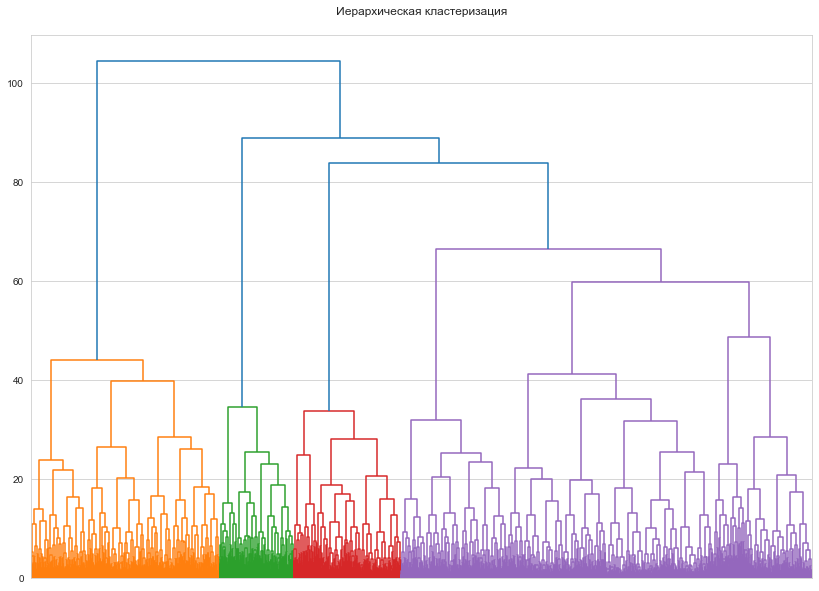

In [17]:
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
sns.set_style('whitegrid')
plt.figure(figsize = (14, 10))  
dendrogram(linked, orientation = 'top', no_labels = True)
plt.title('Иерархическая кластеризация', pad = 20)
plt.show;

**Вывод:** На основании полученного графика можно выделить 4 кластера.

На основании алгоритма K-Means cпрогнозируем кластеры клиентов:

In [18]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_st)
df['cluster_km'] = labels
cluster = df.groupby(['cluster_km']).mean().reset_index()
cluster

,cluster_km,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
1,1,0.480787,0.812559,0.000000,0.086223,1.000000,1.866917,0.325211,28.145267,131.369042,1.791003,2.345829,1.325865,1.086883,0.550141
2,2,0.559567,0.858002,0.338147,0.197353,0.998797,2.730445,0.448857,30.196149,164.579011,2.519856,5.010830,2.928140,2.934140,0.048135
3,3,0.509603,0.750320,1.000000,0.451985,1.000000,2.554417,0.303457,28.499360,129.812508,2.370038,2.832266,1.355379,1.176172,0.395647
4,4,0.495726,0.943376,0.752137,0.541667,1.000000,11.352564,0.564103,29.993590,164.563799,10.376068,4.817308,2.028169,2.020129,0.023504


In [19]:
pd.options.mode.chained_assignment = None
drain = cluster[['cluster_km', 'Churn']]
drain['Отток, %'] = (drain['Churn'] * 100).round(2)
drain = drain[['cluster_km','Отток, %']]
drain = drain.rename(columns={'cluster_km':'Кластер'})
drain

,Кластер,"Отток, %"
0,0,26.75
1,1,55.01
2,2,4.81
3,3,39.56
4,4,2.35


**Вывод:** Описание кластеров:

**Кластер 0**
 - Отток - 2.77% - самый низкий
 - Преобладают сотрудники компаний-партнеров - 78%
 - Живут или работают недалеко от фитнес-центра
 - Чаще всех посещают групповые занятия - 54%
 - Чаще всех пришли по промо акции
 - Договора на длительный срок - в среднем 12 месяца

**Кластер 1**
 - Отток - 26.75%
 - Живут или работают недалеко от фитнес-центра
 - Нет мобильного номера

**Кластер 2**
 - Отток - 44.36%
 - Живут или работают в другом районе
 - 7% пришли по промо акции - самый низкий
 - Реже всех посещают групповые занятия

**Кластер 3**
 - Отток - 51.43% - самый высокий
 - Живут или работают недалеко от фитнес-центра
 - Наименьшее кол-во посещений за всё время и в последний месяц
 - Реже всех посещают клуб - 1.25 раз в неделю

**Кластер 4**
 - Отток - 6.81%
 - Живут или работают недалеко от фитнес-центра
 - Чаще всех посещают клуб - 2.85 раз в неделю
 - Договора НЕ на длительный срок - в среднем 3 месяца


Построим распределения признаков для кластеров. Можем ли мы что-то заметить по ним?

Кластер 0:


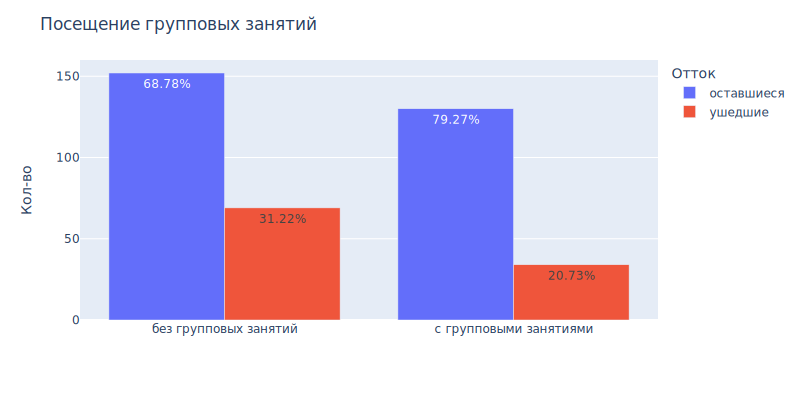

Кластер 1:


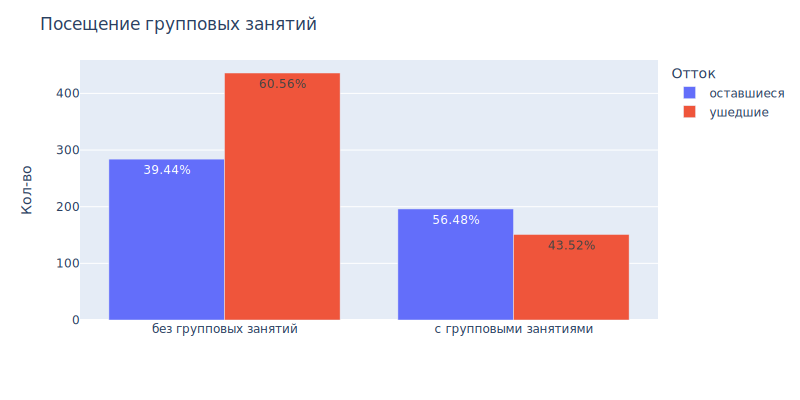

Кластер 2:


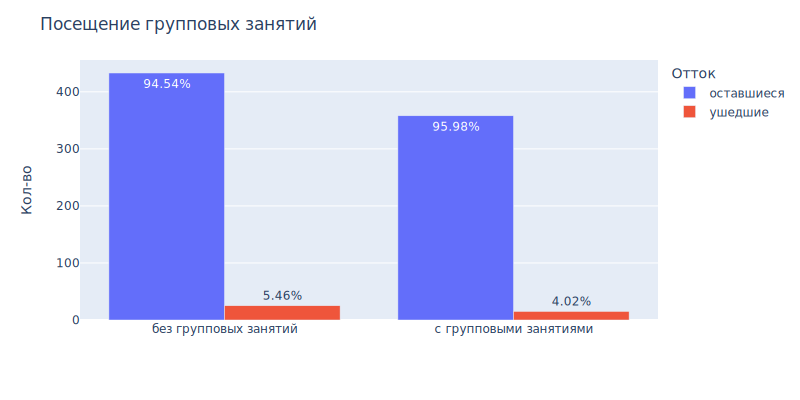

Кластер 3:


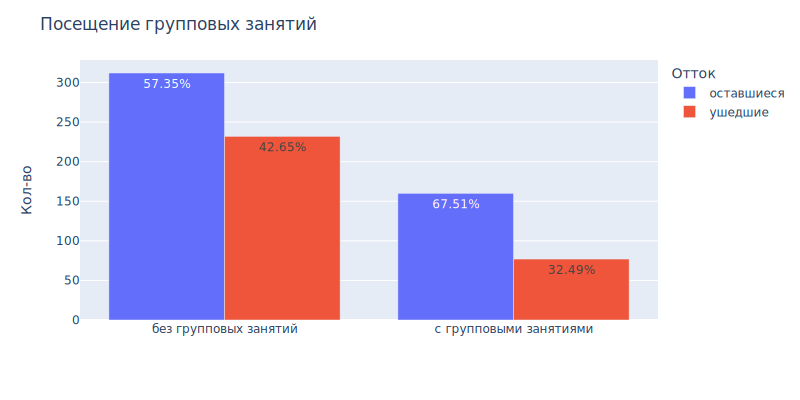

Кластер 4:


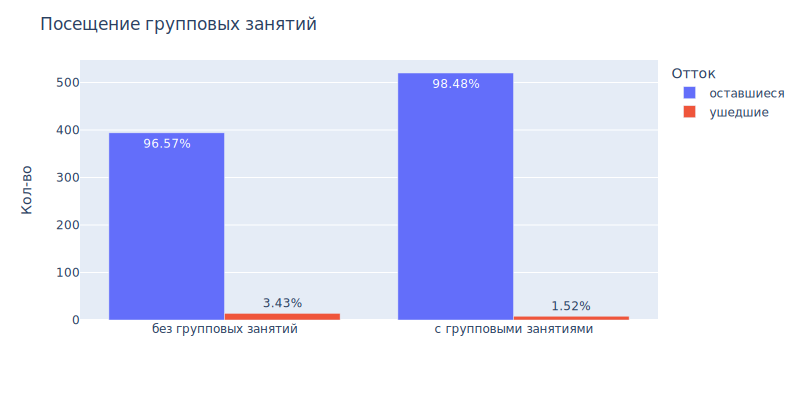

Кластер 0:


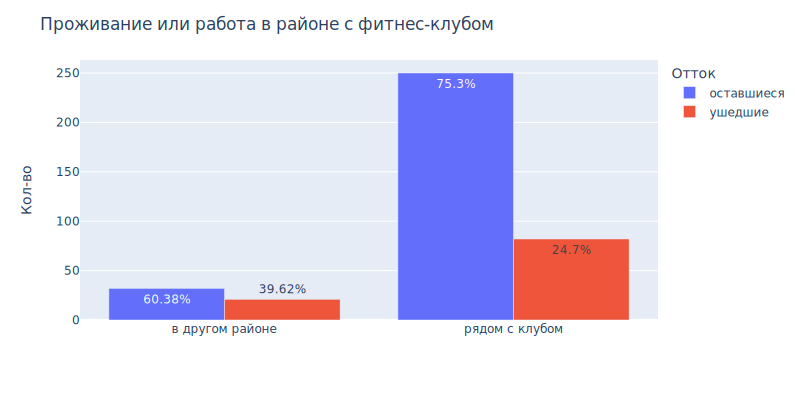

Кластер 1:


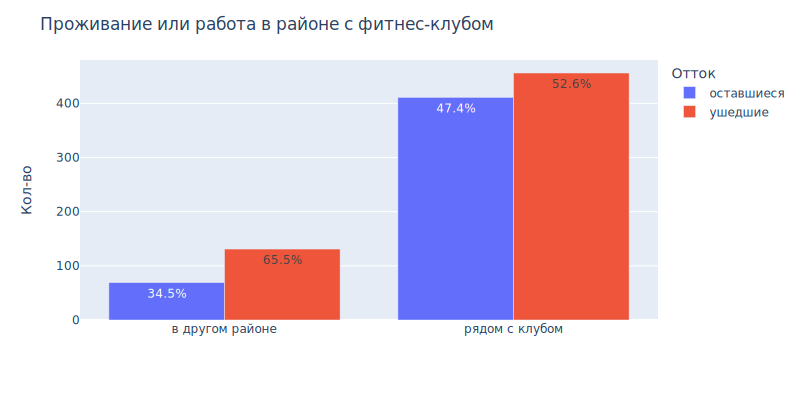

Кластер 2:


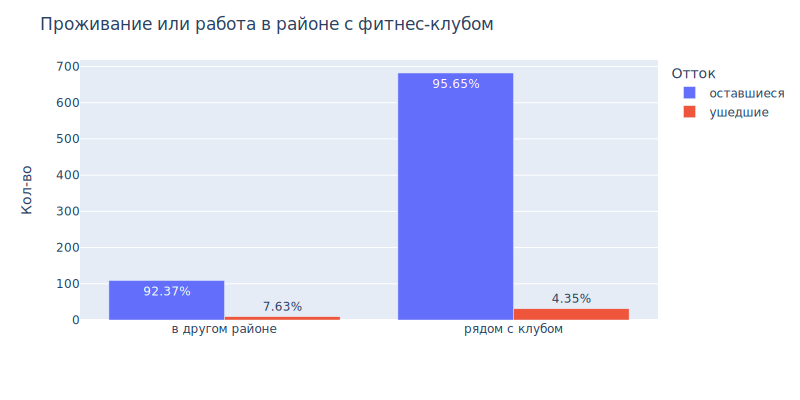

Кластер 3:


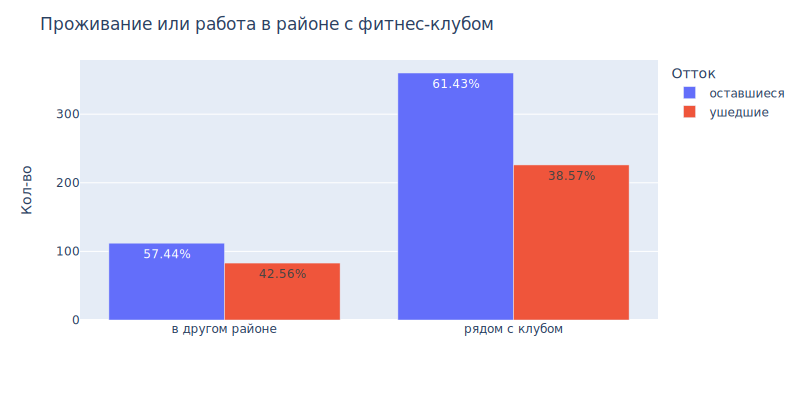

Кластер 4:


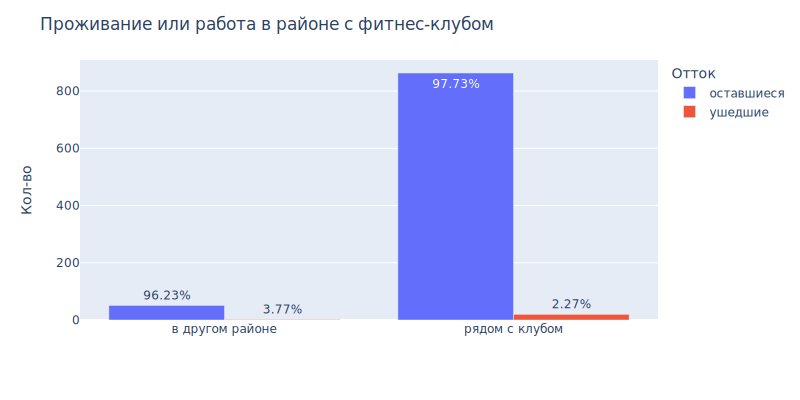

Кластер 0:


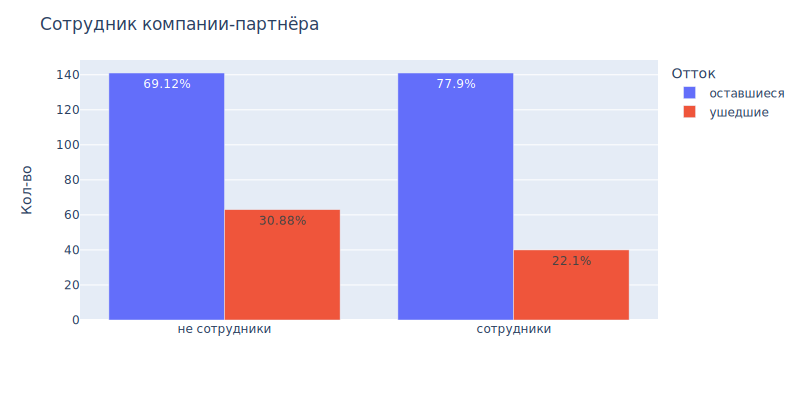

Кластер 1:


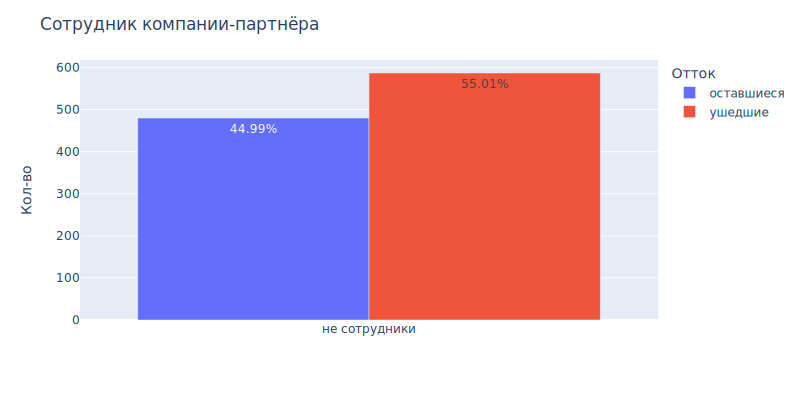

Кластер 2:


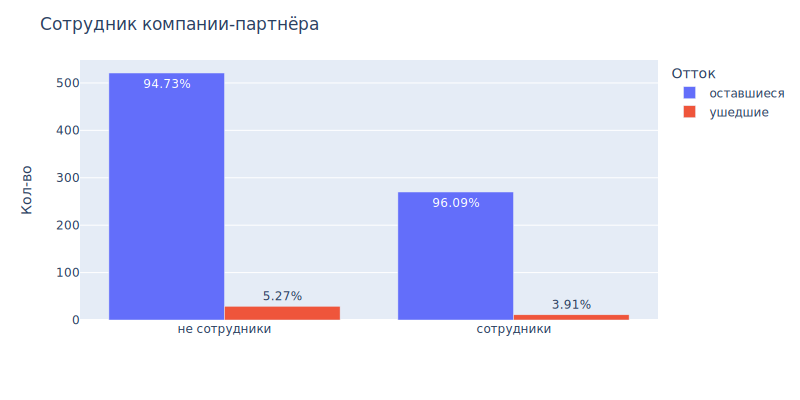

Кластер 3:


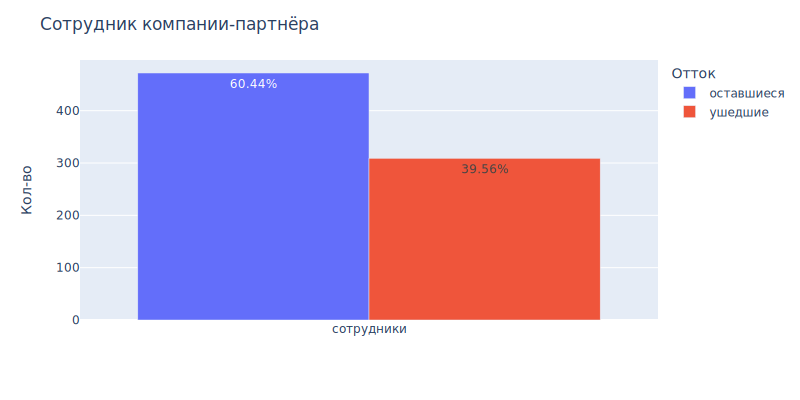

Кластер 4:


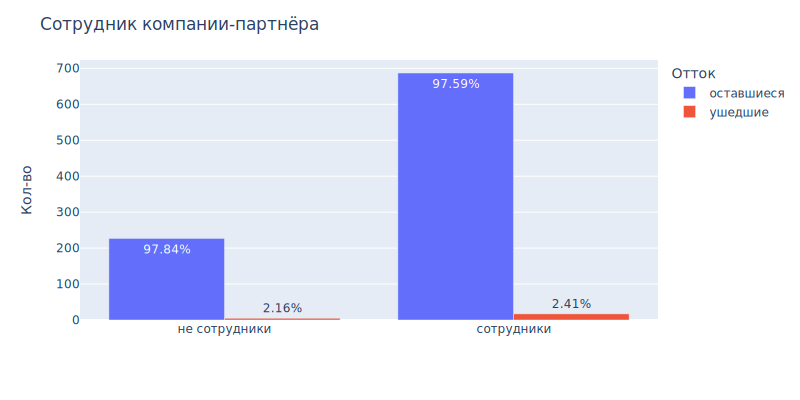

Кластер 0:


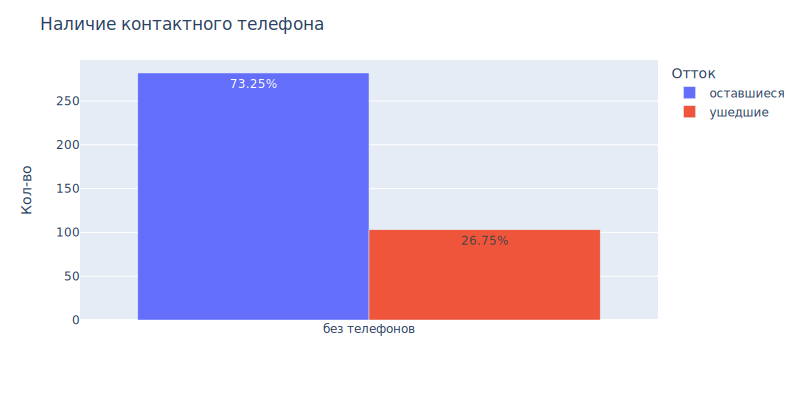

Кластер 1:


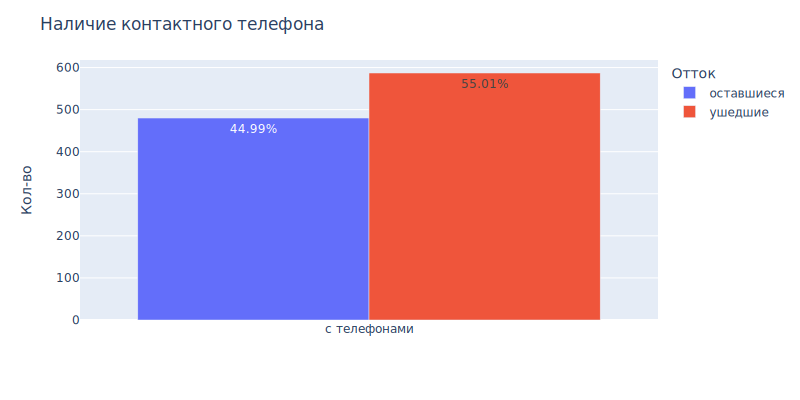

Кластер 2:


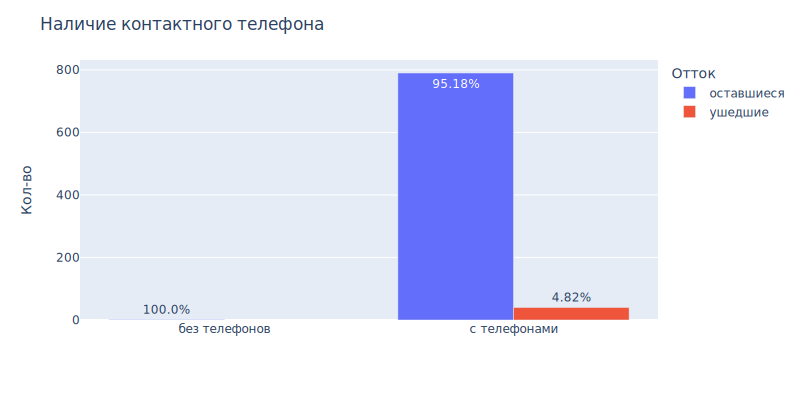

Кластер 3:


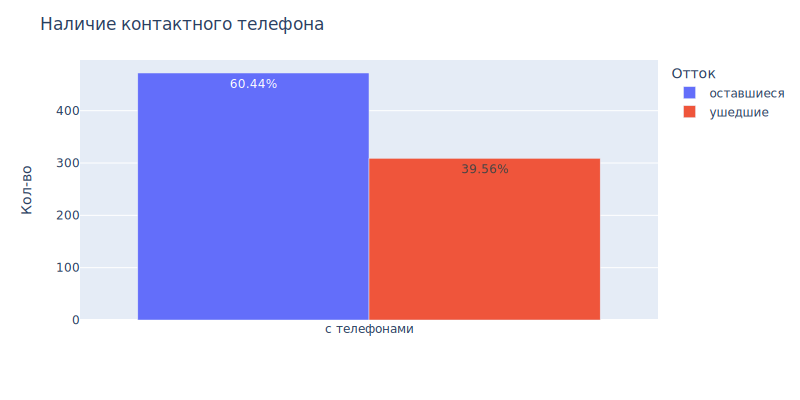

Кластер 4:


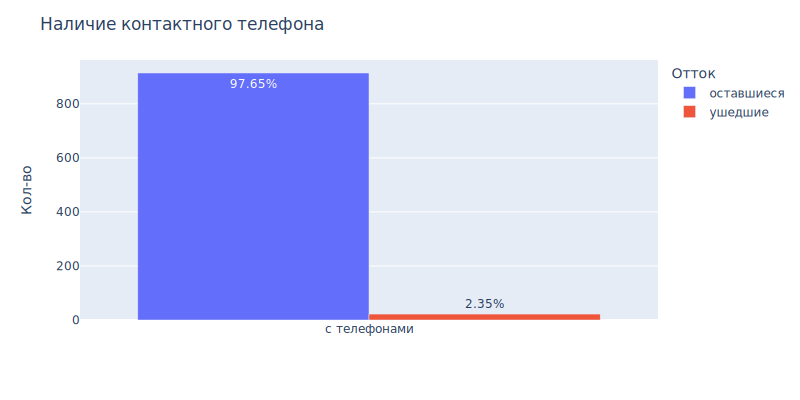

Кластер 0:


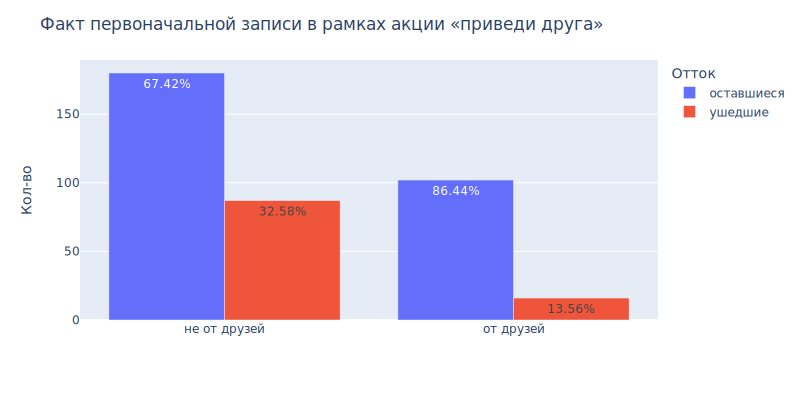

Кластер 1:


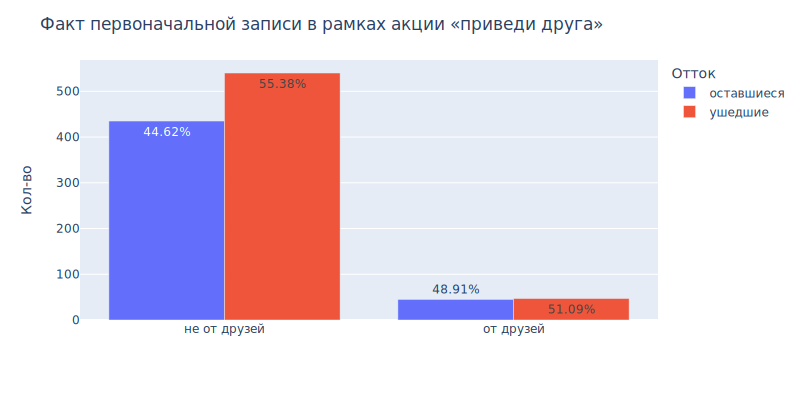

Кластер 2:


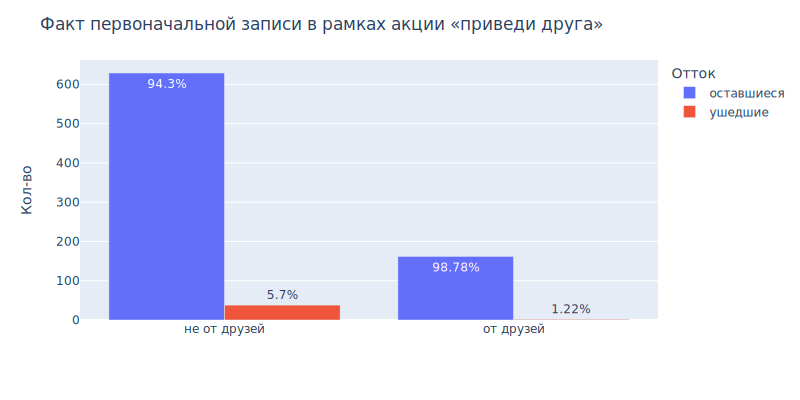

Кластер 3:


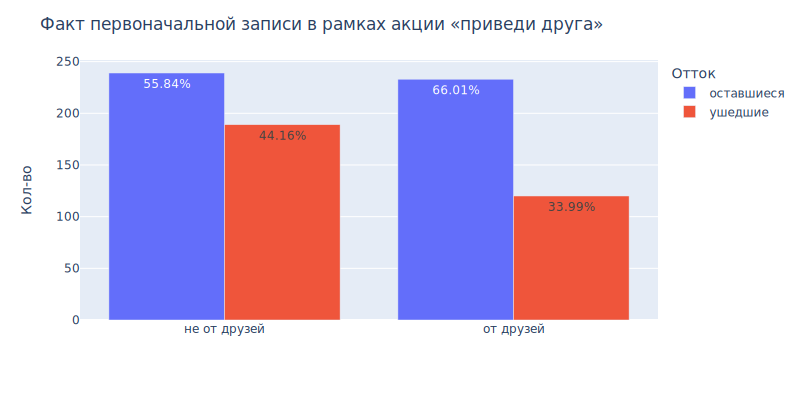

Кластер 4:


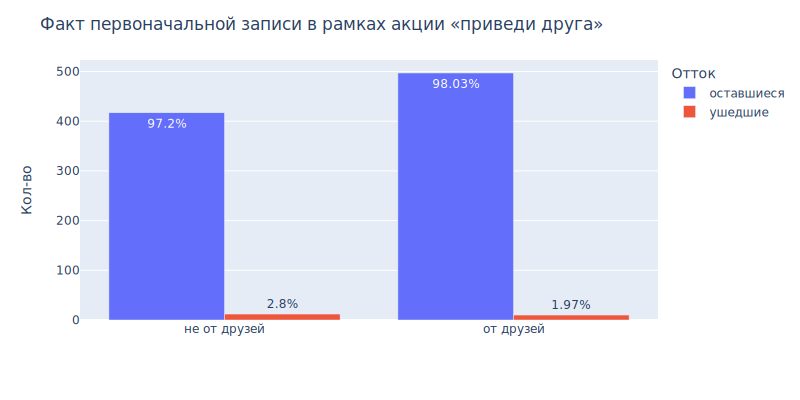

Кластер 0:


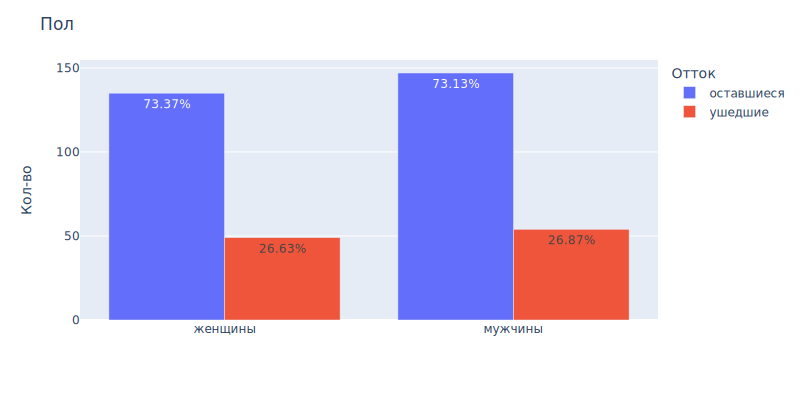

Кластер 1:


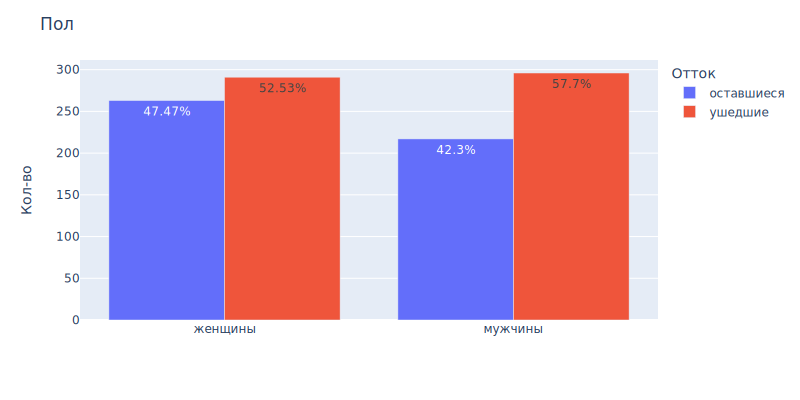

Кластер 2:


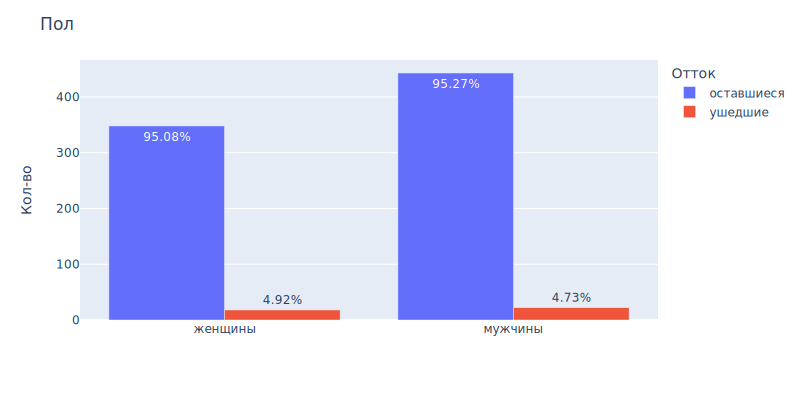

Кластер 3:


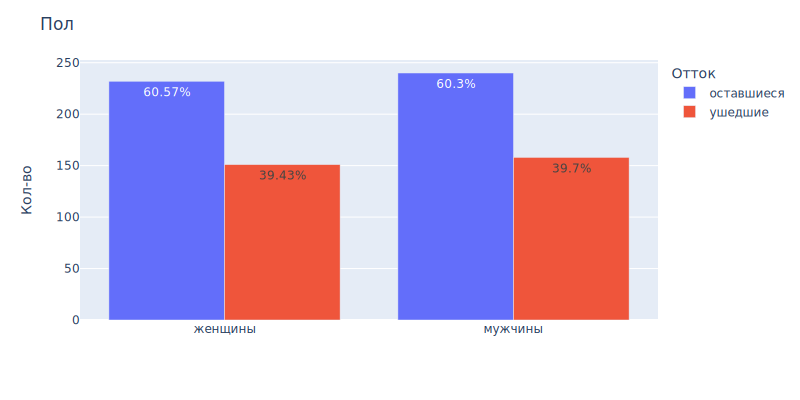

Кластер 4:


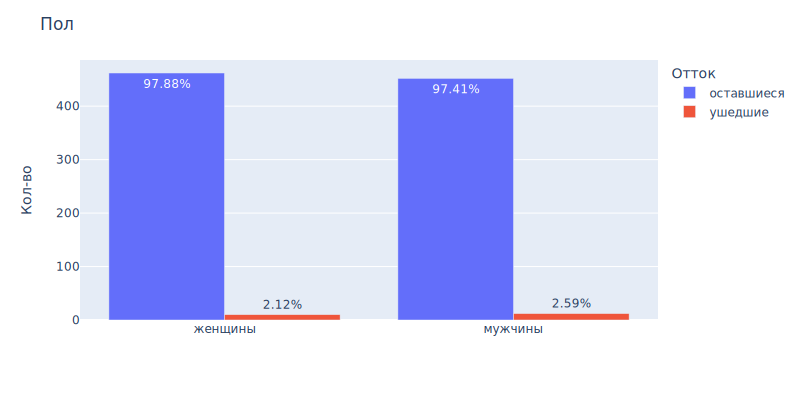

Кластер 0:


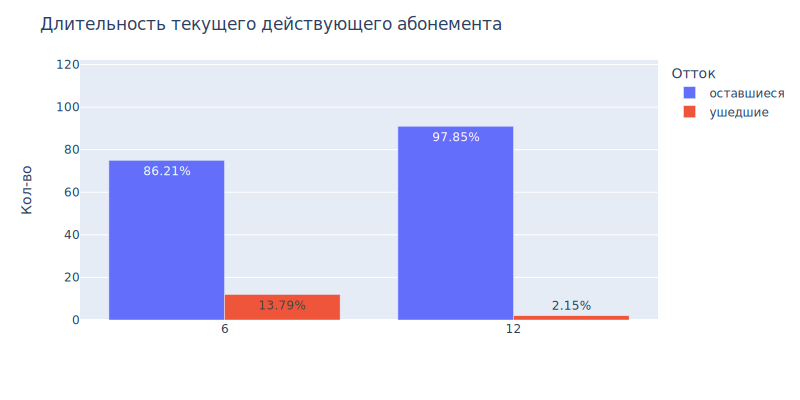

Кластер 1:


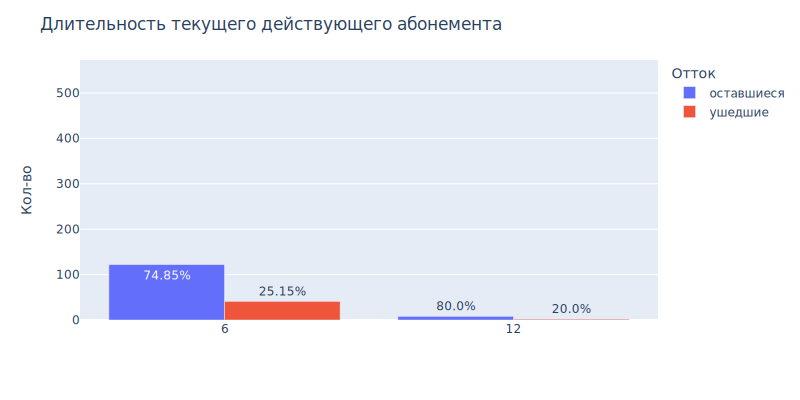

Кластер 2:


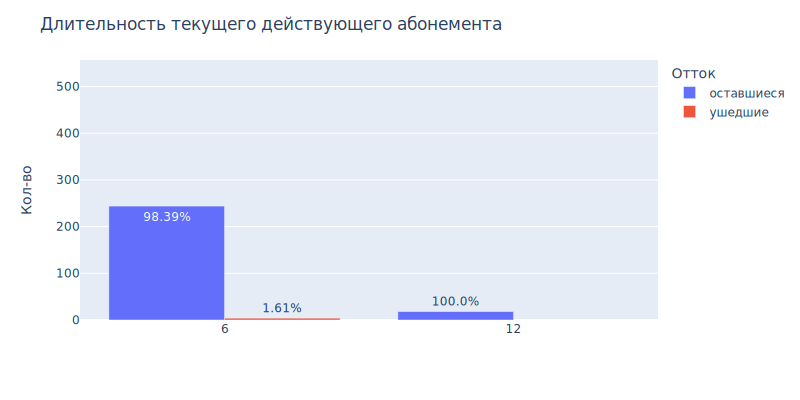

Кластер 3:


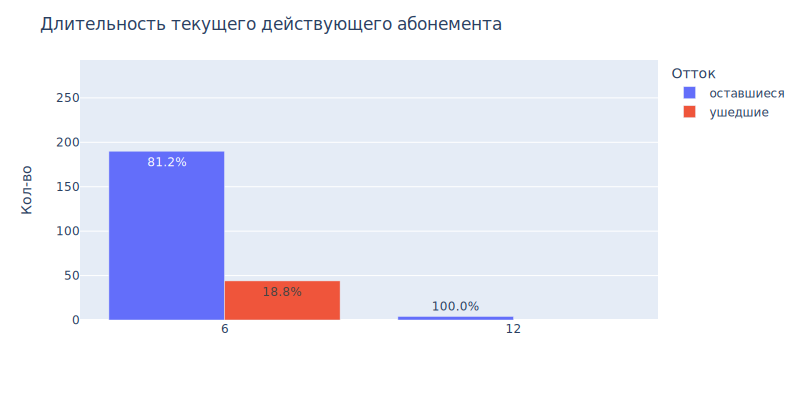

Кластер 4:


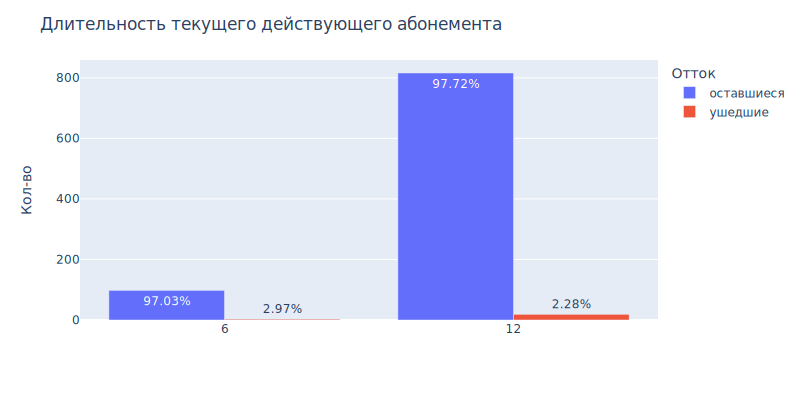

Кластер 0:


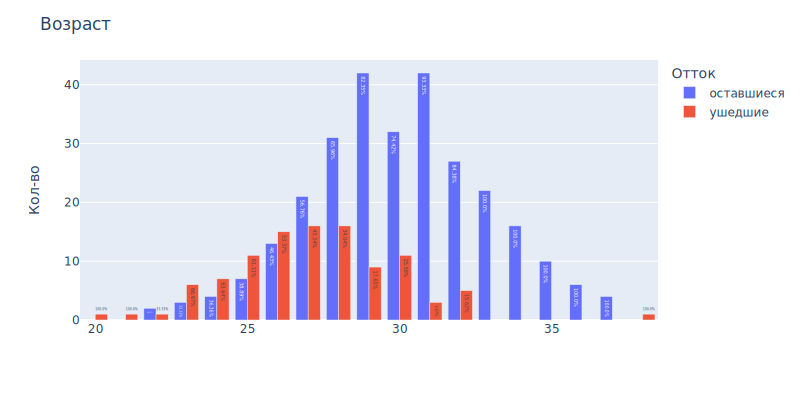

Кластер 1:


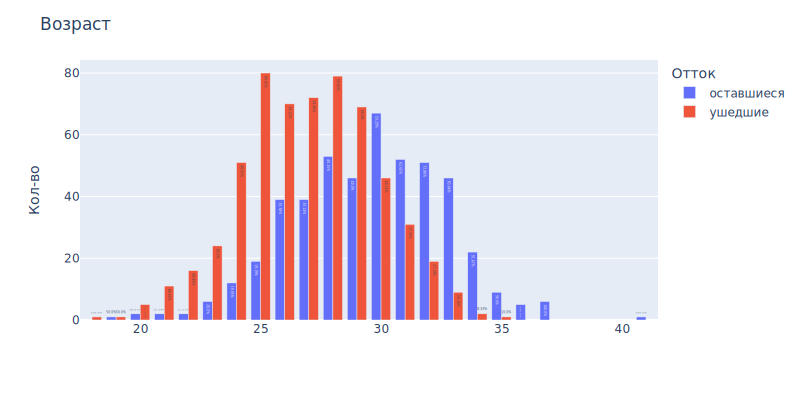

Кластер 2:


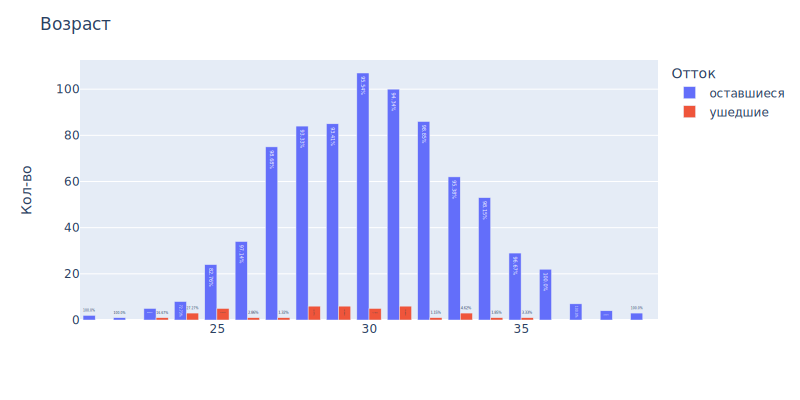

Кластер 3:


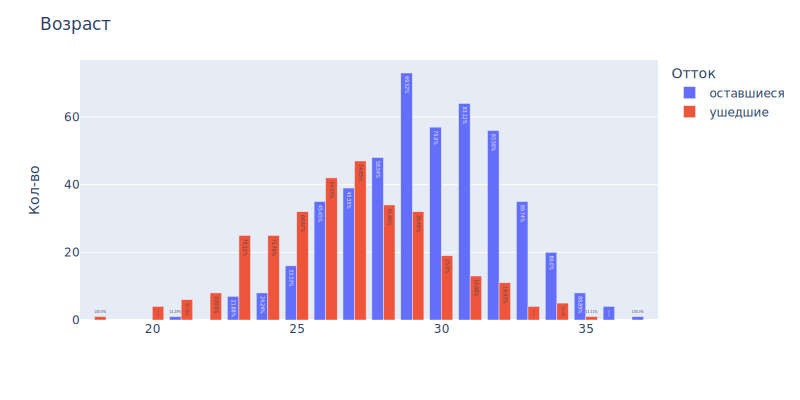

Кластер 4:


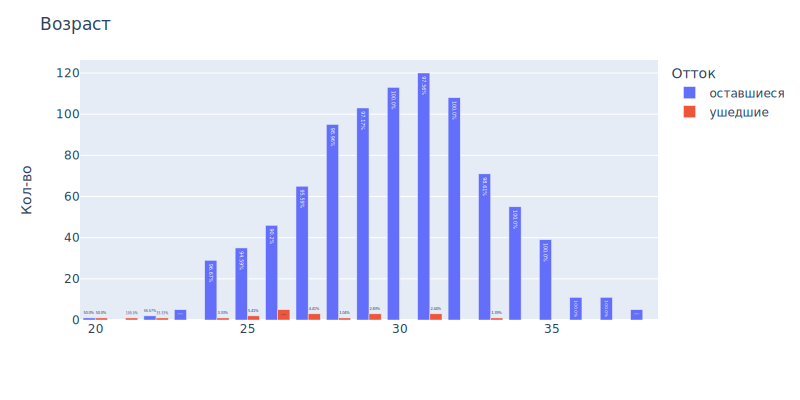

Кластер 0:


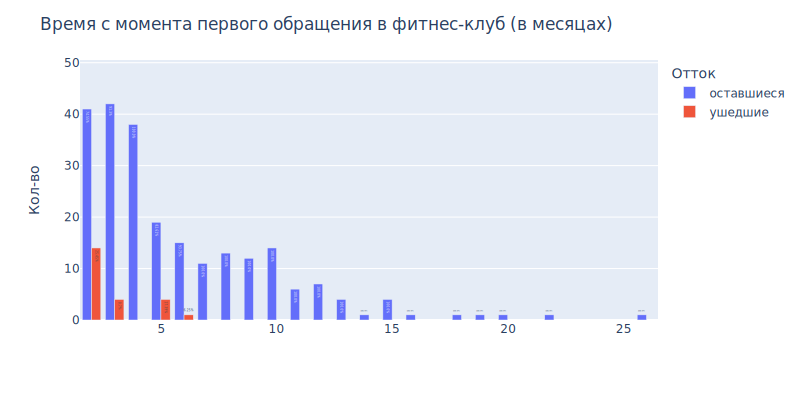

Кластер 1:


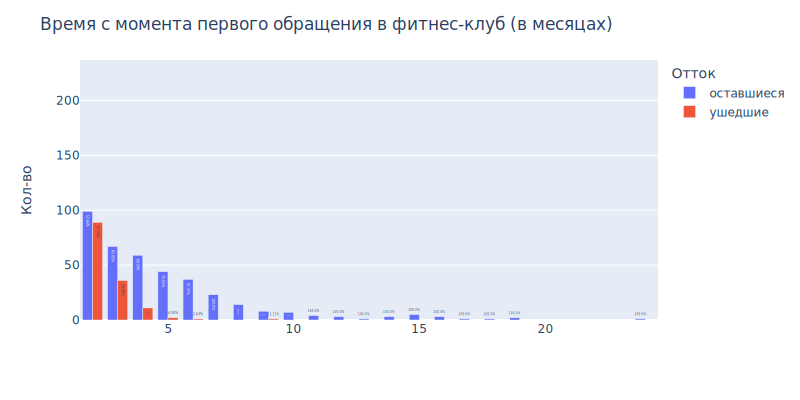

Кластер 2:


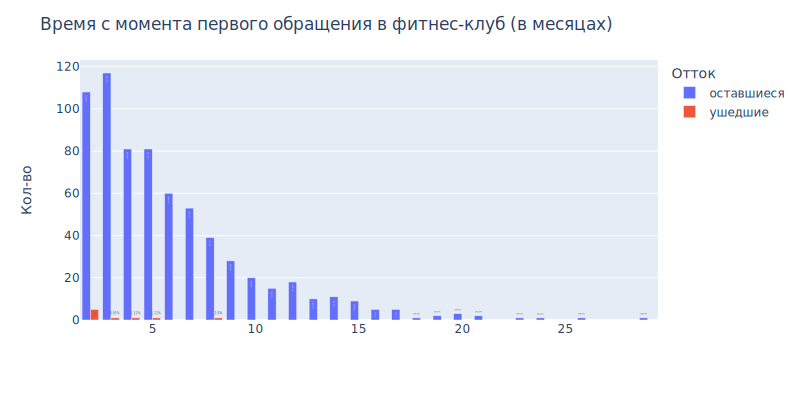

Кластер 3:


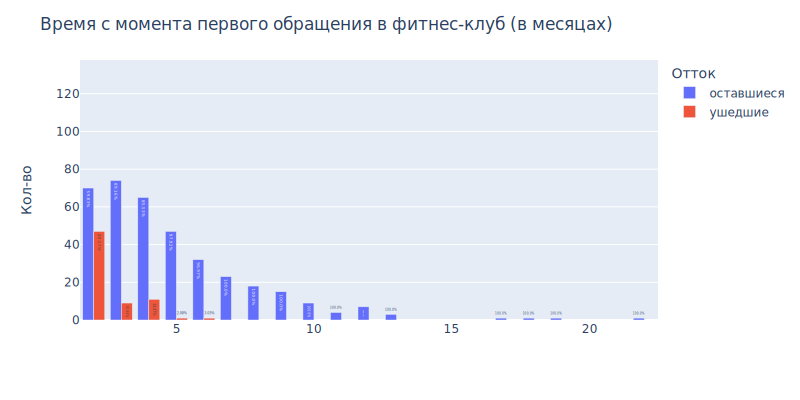

Кластер 4:


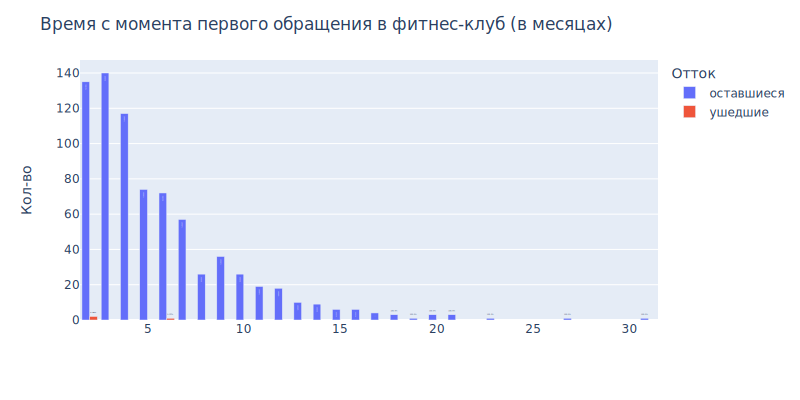

Кластер 0:


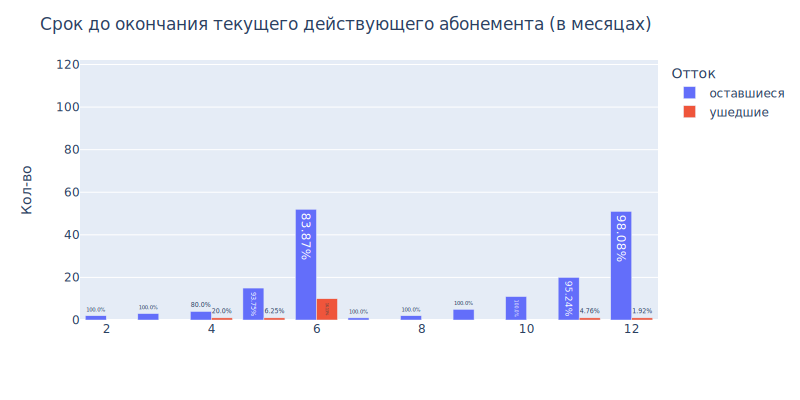

Кластер 1:


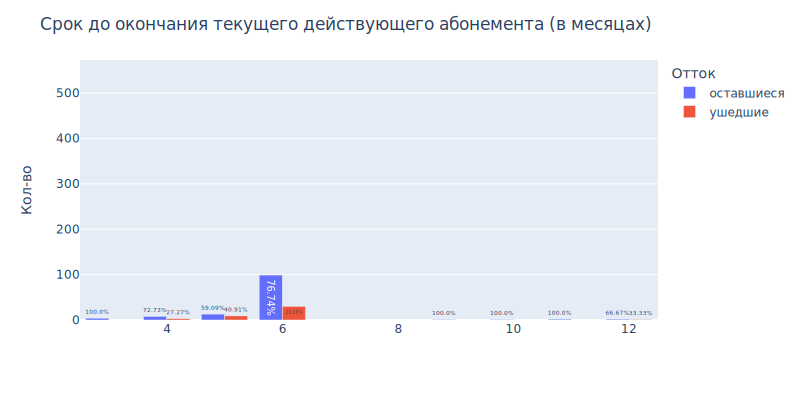

Кластер 2:


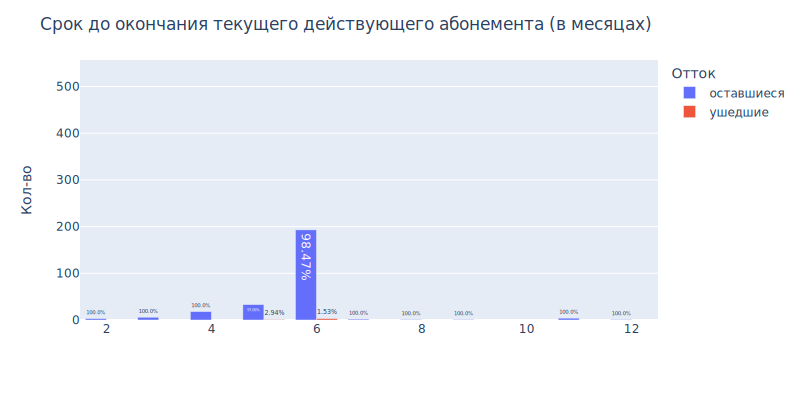

Кластер 3:


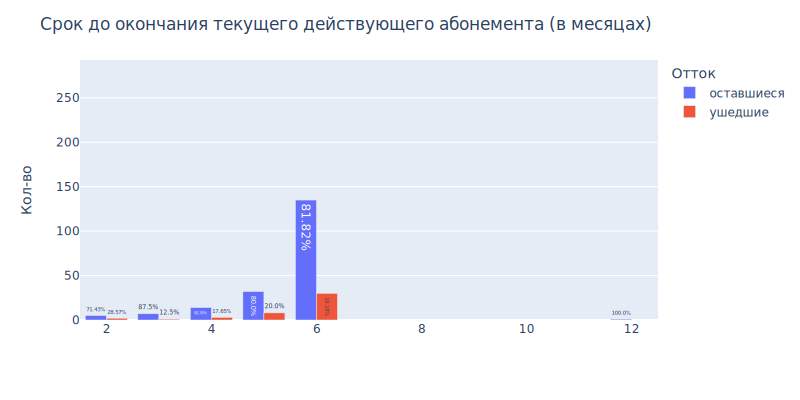

Кластер 4:


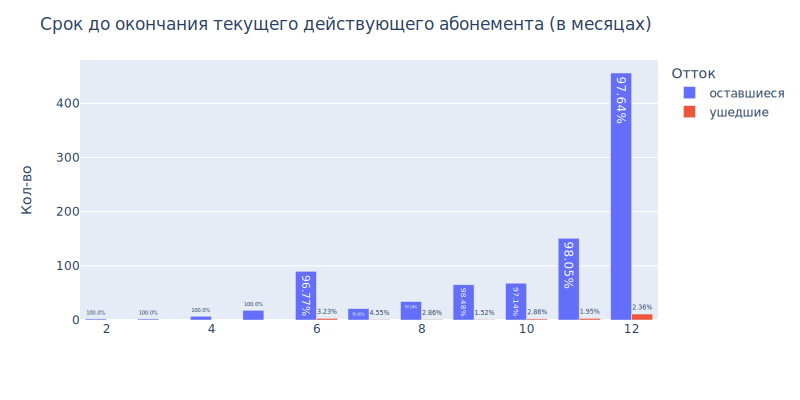

In [20]:
claster_list = [0, 1, 2, 3, 4]
for attribute, title, label in zip(attribute_list, title_attribute, label_attribute): 
    for i in claster_list:
        df_claster = df[df['cluster_km'] == i]
        print('Кластер {}:'.format(i))
        print_bar(df_claster, attribute, title, label)

# Выводы:

**Выводы по имеющимся данным:**
    
 - Распределение по полу примерно одинаково
 - Большинство клиентов (85%) живет или работает рядом с фитнес-клубом
 - Примерно половина клиентов являются сотрудниками партнерских организаций
 - Около 30% клиентов пришли по программе "Приведи друга"
 - Известны мобильные номера примерно 90% клиентов
 - Средняя длительность абонементов клиентов - 4.6 месяцев
 - Около 41% клиентов посещают групповые занятия
 - Средний возраст клиентов 29 лет
 - Средние дополнительные расходы на клиента - 146
 - Средний срок до окончания договора - 4.3 месяцев
 - Среднее время с момента первого обращения в фитнес-центр - 3.7 месяцев
 - Средняя частота посещений за все время - 1.87 раз в неделю
 - Средняя частота посещений за последний месяц - 1.76 раз в неделю
 - Доля оттока - 27%
 
**Выводы на основе отличий признаков у клиентов, попавших в отток и оставшихся:**

 - Распределение по полу не отличается
 - Ближе живущие или работающие клиенты реже попадают в отток, что вполне логично
 - Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб чем остальные клиенты
 - Клиенты, пришедшие по акции "Приведи друга" в два раза реже уходят в отток
 - Наличие мобильного номера клиента не отличается в группах
 - У групп есть разница в среднем возрасте клиентов
 - Оставшееся время до окончания срока действия договора логично больше у оставшихся клиентов.
 
 
 **Вывод на основе разбивки на 5 кластеров:**

**Кластер 0**
 - Отток - 2.77% - самый низкий
 - Преобладают сотрудники компаний-партнеров - 78%
 - Живут или работают недалеко от фитнес-центра
 - Чаще всех посещают групповые занятия - 54%
 - Чаще всех пришли по промо акции
 - Договора на длительный срок - в среднем 12 месяца

**Кластер 1**
 - Отток - 26.75%
 - Живут или работают недалеко от фитнес-центра
 - Нет мобильного номера

**Кластер 2**
 - Отток - 44.36%
 - Живут или работают в другом районе
 - 7% пришли по промо акции - самый низкий
 - Реже всех посещают групповые занятия

**Кластер 3**
 - Отток - 51.43% - самый высокий
 - Живут или работают недалеко от фитнес-центра
 - Наименьшее кол-во посещений за всё время и в последний месяц
 - Реже всех посещают клуб - 1.25 раз в неделю

**Кластер 4**
 - Отток - 6.81%
 - Живут или работают недалеко от фитнес-центра
 - Чаще всех посещают клуб - 2.85 раз в неделю
 - Договора НЕ на длительный срок - в среднем 3 месяца
 
 
**Рекомендации:**
Вероятно, если абонемент куплен на 1 месяц, то человек ещё не понял хочет ли он вообще заниматься и понравится ли ему конкретно в этом клубе. Многие с такими абонементами уходят, и если предполагать, что это «новички», то возможно можно как-то скрасить первый месяц пребывания человека в клубе, чтобы он купил абонемент на более длительный срок. Для этого можно провести отдельное исследование о том сколько людей впервые посетившие клуб покупают следующий абонемент.
Основная ценность проделанной работы - это возможность предсказывать вероятность оттока в последующий месяц клиентов, благодаря чему менеджеры клуба могут фокусироваться на клиентах, которых клуб может потерять.